In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import time, random

from qiskit import BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua import QuantumInstance, set_qiskit_aqua_logging
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Pauli
from qiskit.optimization.ising import max_cut, tsp
from qiskit.optimization.ising.common import sample_most_likely, random_graph

import logging

[[0. 2. 1. 4. 0. 0.]
 [2. 0. 1. 0. 0. 0.]
 [1. 1. 0. 2. 0. 0.]
 [4. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


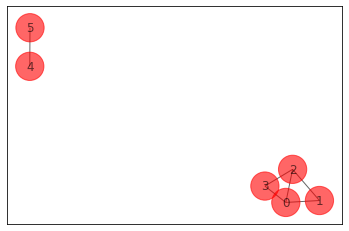

In [2]:
# generate a graph

n = 6
build_random_graph = False

if not build_random_graph:
    G = nx.Graph()
    G.add_nodes_from(np.arange(0, n, 1))
#     E = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),(4,5,1.0),(2,4,1.0),(3,4,1.0),(0,5,1.0)]
    E = [(0,1,2.0),(0,2,1.0),(0,3,4.0),(1,2,1.0),(2,3,2.0),(4,5,1.0)]
    G.add_weighted_edges_from(E)

    colors = ['r' for node in G.nodes()]
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

    # build a weight matrix from G
    w = np.zeros([n,n])
    for i, j, data in G.edges.data():
        w[i][j] = data['weight']
        w[j][i] = data['weight']

else: # random graph
    np.random.seed(8123179)
    w = random_graph(n, edge_prob=0.5, weight_range=2, negative_weight=True)
    qubitOp, offset = max_cut.get_operator(w)
print(w)

#### Convert adjacency matrix to Hamiltonians

Example listed [here](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747). For a given edge, the two nodes being connected will be represented with Z and others X. 

In [3]:
from qiskit.quantum_info import Pauli
ixzy = Pauli([True, True, False, False], [True, False, True, False])
print(ixzy)   # How we define gates

IXZY


In [4]:
def adj2paulis(adjM):
    n = adjM.shape[0]  # num nodes
    paulis = []
    offset = 0
    for i in range(n):
        for j in range(i):
            if adjM[i, j] != 0:
                x_p = np.zeros(n, dtype=np.bool)  
                z_p = np.zeros(n, dtype=np.bool)
                z_p[i], z_p[j] = True, True  
                paulis.append([0.5 * adjM[i,j], Pauli(z_p, x_p)])
                offset -= 0.5 * adjM[i, j]
    return WeightedPauliOperator(paulis=paulis), offset

In [5]:
wpo, offset = adj2paulis(w)
print(wpo.print_details())
print("offset: ", offset)
print(wpo.to_dict())

IIIIZZ	(1+0j)
IIIZIZ	(0.5+0j)
IIIZZI	(0.5+0j)
IIZIIZ	(2+0j)
IIZZII	(1+0j)
ZZIIII	(0.5+0j)

offset:  -5.5
{'paulis': [{'label': 'IIIIZZ', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'IIIZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'IIIZZI', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'IIZIIZ', 'coeff': {'real': 2.0, 'imag': 0.0}}, {'label': 'IIZZII', 'coeff': {'real': 1.0, 'imag': 0.0}}, {'label': 'ZZIIII', 'coeff': {'real': 0.5, 'imag': 0.0}}]}


In [6]:
def weightedPaulisToPaulis(wpo):
    """
    @param wpo: Weighted PauliOperator
    @return ps: Pauli Operator list
        [(label, coeff, pauli object), ...]
        will use the pauli object to instruction for circuit building
    """
    ps = []
    wpos = wpo.to_dict()['paulis']
    for d in wpos:
        label, coeff = d['label'], d['coeff']['real']
        pauli = Pauli(label=label)
        ps.append((label, coeff, pauli))
    return ps

In [7]:
wpo.to_dict()['paulis'][0]
Pauli(label='IZIZ')

Pauli(z=[True, False, True, False], x=[False, False, False, False])

In [8]:
wpo.to_dict()

{'paulis': [{'label': 'IIIIZZ', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'IIIZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IIIZZI', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IIZIIZ', 'coeff': {'real': 2.0, 'imag': 0.0}},
  {'label': 'IIZZII', 'coeff': {'real': 1.0, 'imag': 0.0}},
  {'label': 'ZZIIII', 'coeff': {'real': 0.5, 'imag': 0.0}}]}

In [9]:
weightedPaulisToPaulis(wpo)

[('IIIIZZ',
  1.0,
  Pauli(z=[True, True, False, False, False, False], x=[False, False, False, False, False, False])),
 ('IIIZIZ',
  0.5,
  Pauli(z=[True, False, True, False, False, False], x=[False, False, False, False, False, False])),
 ('IIIZZI',
  0.5,
  Pauli(z=[False, True, True, False, False, False], x=[False, False, False, False, False, False])),
 ('IIZIIZ',
  2.0,
  Pauli(z=[True, False, False, True, False, False], x=[False, False, False, False, False, False])),
 ('IIZZII',
  1.0,
  Pauli(z=[False, False, True, True, False, False], x=[False, False, False, False, False, False])),
 ('ZZIIII',
  0.5,
  Pauli(z=[False, False, False, False, True, True], x=[False, False, False, False, False, False]))]

#### Exact Answer
---

In [10]:
# Exact Eigensolver
ee = ExactEigensolver(wpo, k=1)
result = ee.run()
print("the ground state energy: ", result["energy"])
print("exact result: ", -1*(result["energy"]+offset))

the ground state energy:  -4.5
exact result:  10.0


case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 7.0
case = [0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0] cost = 6.0
case = [0, 0, 1, 0, 0, 0] cost = 4.0
case = [1, 0, 1, 0, 0, 0] cost = 9.0
case = [0, 1, 1, 0, 0, 0] cost = 5.0
case = [1, 1, 1, 0, 0, 0] cost = 6.0
case = [0, 0, 0, 1, 0, 0] cost = 6.0
case = [1, 0, 0, 1, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0] cost = 9.0
case = [1, 1, 0, 1, 0, 0] cost = 4.0
case = [0, 0, 1, 1, 0, 0] cost = 6.0
case = [1, 0, 1, 1, 0, 0] cost = 3.0
case = [0, 1, 1, 1, 0, 0] cost = 7.0
case = [1, 1, 1, 1, 0, 0] cost = 0.0
case = [0, 0, 0, 0, 1, 0] cost = 1.0
case = [1, 0, 0, 0, 1, 0] cost = 8.0
case = [0, 1, 0, 0, 1, 0] cost = 4.0
case = [1, 1, 0, 0, 1, 0] cost = 7.0
case = [0, 0, 1, 0, 1, 0] cost = 5.0
case = [1, 0, 1, 0, 1, 0] cost = 10.0
case = [0, 1, 1, 0, 1, 0] cost = 6.0
case = [1, 1, 1, 0, 1, 0] cost = 7.0
case = [0, 0, 0, 1, 1, 0] cost = 7.0
case = [1, 0, 0, 1, 1, 0] cost = 6.0
case = [0, 1, 0, 1, 1, 0] cost = 10.0

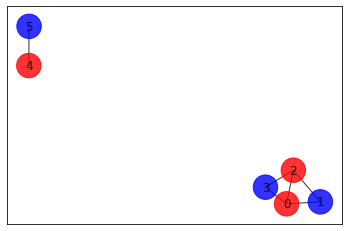

In [11]:
# Brute Force
# brute force
import time
start = time.time()
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute <= cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute) + ' time taken: {:.5f}s'.format(time.time()-start))

#### Approximator

In [48]:
def prep_ansantz(qc, params):
    # requires 2*n params
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 2*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
    for i in range(n):
        qc.rx(params[2*i], q[i])
        qc.ry(params[2*i+1], q[i])
        
    for i in range(n):
        if i < n-1:
            qc.cnot(q[i], q[i+1])
    return qc

def prep_ansantz2(qc, params):
    # requires 6*n params
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 6*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
    for i in range(n):
        qc.rx(params[2*i], q[i])
        qc.ry(params[2*i+1], q[i])
            
    qc.barrier()
    for i in range(n):
        if i < n-1:
            qc.cnot(q[i], q[i+1])
            qc.rx(params[2*i+3], q[i+1])
            qc.ry(params[2*i+4], q[i+1])
    
    qc.barrier()
    for i in range(n):
        qc.rx(params[2*i+5], q[i])
        qc.ry(params[2*i+6], q[i])
    return qc


def prep_ansantz3(qc, params, layers=2):
    # requires 12*params
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 12*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
        
    for i in range(n):
        qc.u3(params[2*i], params[2*i+1], params[2*i+2], q[i])

    qc.barrier()
    for i in range(n):
        if i < n-1:
            qc.cnot(q[i], q[i+1])
            qc.u3(params[2*i+3], params[2*i+4], params[2*i+5], q[i+1])
    
    qc.barrier()
    for i in range(n):
        qc.u3(params[2*i+6], params[2*i+7], params[2*i+8], q[i])

    qc.barrier()
    for i in range(n):
        if i < n-1:
            qc.cnot(q[i], q[i+1])
            qc.u3(params[2*i+9], params[2*i+10], params[2*i+11], q[i+1])

    qc.barrier()
    return qc

In [49]:
# Im gonna go for a custom one, but may need to use something like RY from
# from qiskit.aqua.components.variational_forms import RY

def vqe_circuit(n, params, pauli_label):
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)
    qc = QuantumCircuit(qr, cr)
    qc = prep_ansantz3(qc, params)
#     qc = prep_ansantz2(qc, params)
    qc.barrier()
    # add the pauli

    for i, gate in enumerate(pauli_label):
        if gate == 'Z':
            qc.z(qr[i])
    # add measurements?
    
    qc.barrier()
    for i in range(n):
        qc.measure(qr[i], cr[i])
    return qc

def get_exp(counts: dict, pauli_label: str):
    """ to get expected value 
    @param counts: dictionary of measurements
    @param pauli label: str - used as a mask
        - when computing (-1)**sum([...]) to determine the eigen value
          only consider the measurements resulting from X, Y, Z gates, not I
    """
    exp, N = 0, 0
    for m, c in counts.items():
        mask = np.array(list(pauli_label)) != 'I'
        m_ = np.array(list(m))[mask]        
        eigen = (-1)**sum([int(i) for i in m_])  # this determine the eigen value of the vector m
        exp += eigen*c
        N += c
    return exp/N

def vqe_module(params, pauli_label, n_shots=1000):
    """
    returns expected value of current iteration and the quantum circuit
    """
    n = len(params) // 12
    qc = vqe_circuit(n, params, pauli_label)
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=n_shots)
    results = job.result()
    counts = results.get_counts()
    expected_value = get_exp(counts, pauli_label)
    return expected_value, qc

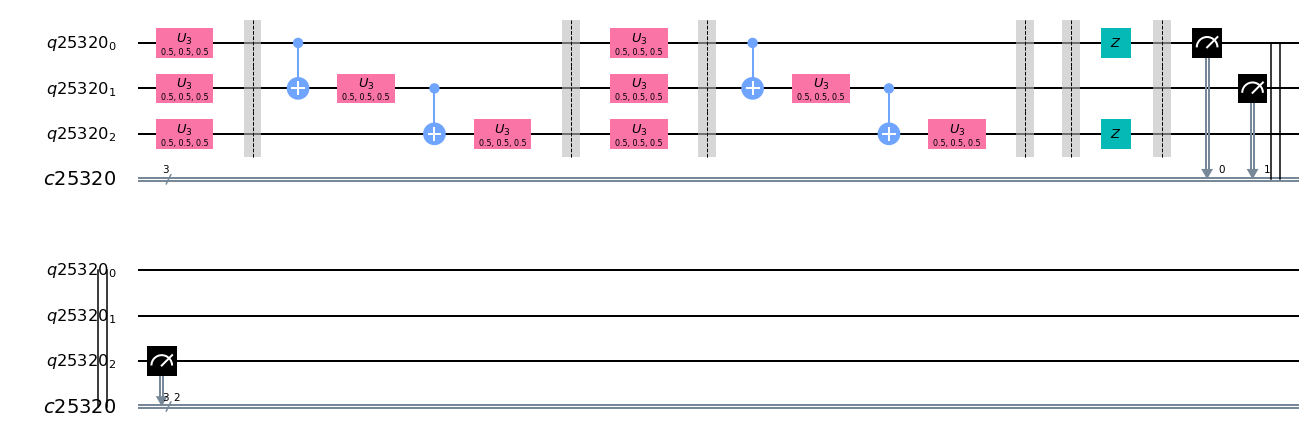

In [50]:
exp, qc = vqe_module([0.5]*3*12, 'ZIZ')
qc.draw(output="mpl")

In [51]:
def vqe(wpo: WeightedPauliOperator, params: list, n_shots:int=1000):
    
    # paulis: [(label, ceof, pauli), ...]
    paulis = weightedPaulisToPaulis(wpo) 
    exp_sum = 0
    for label, coef, _ in paulis:
        exp_sum += coef*vqe_module(params, label, n_shots)[0]
    return exp_sum

### Experiment

In [52]:
wpo, offset = adj2paulis(w)

In [55]:
from scipy.optimize import minimize

# optimize
params = np.array([random.random() for _ in range(n*12)])
tolerance = 1e-6
n_shots = 1000
vqe_wrapper = lambda x: vqe(wpo, params=x, n_shots=n_shots)
%time vqe_result = minimize(vqe_wrapper, params, method="Powell", tol=tolerance)

CPU times: user 34min 17s, sys: 23.5 s, total: 34min 40s
Wall time: 36min 46s


In [56]:
vqe_result.x

array([  3.18326738,   5.75635234,   0.21058733,   0.15380481,
         0.65502069,   0.61753804,   0.26319395,   0.36341492,
         0.28913974,   0.39075776,  -0.10115359,   0.12211056,
         0.43319835,   0.36789405,   4.47219158,   0.60755349,
         0.04150182,  -0.20308194,   2.76749689,  -0.60412588,
         7.10650894,   5.48314132,   6.30660354,  -3.14885343,
         4.39789497,   4.55831684,   0.04690578,   5.12418836,
         0.24629386,   7.17322454,   4.46577581,  -0.35196642,
        -1.99863256,   3.10218539,   2.33209507, -10.57871003,
         6.59722037,   9.38588543,  -4.3668182 ,   5.23447638,
         4.50755304, -17.10859191,   0.1575748 ,  10.79657749,
         0.0392786 ,   1.61415212,  -1.19225731,   4.54522777,
         3.22927923,   4.15889129,   3.47809144,   6.64388559,
         8.07055373,   4.63424515,  22.14535652,   7.53340311,
         0.68458794,   7.5575856 ,  -4.75715239,   0.09073051,
        -4.27374997,   1.86024904,   3.65694086,   3.70

In [57]:
print("the ground state energy: ", result["energy"])
print("vqe ground state energy: ", vqe_result.fun)
print("vqe result: ", -1*(vqe_result.fun + offset))

the ground state energy:  -4.5
vqe ground state energy:  -4.387
vqe result:  9.887


#### Get Eigen-vectors

In [59]:
def get_eigenvectors(params, n_shots=1000):
    n = len(params) // 12
    qc = vqe_circuit(n, params, "I"*n)
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=n_shots)
    results = job.result()
    counts = results.get_counts()
    return counts

counts = get_eigenvectors(vqe_result.x)

In [60]:
eigen_vec = sample_most_likely(counts)
print(eigen_vec)

[1 0 1 0 1 0]


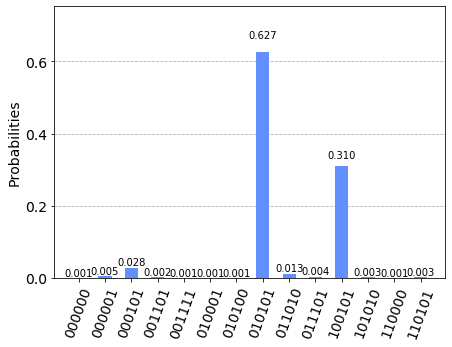

In [61]:
plot_histogram(counts)

### Scratch work

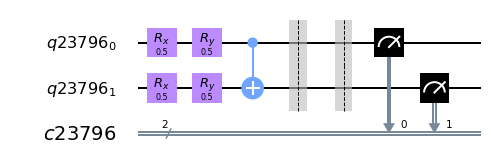

In [19]:
vqe_qc = vqe_circuit(2, [0.5, 0.5]*2, 'II')
vqe_qc.draw(output='mpl')

In [20]:
N=1000
backend = BasicAer.get_backend('qasm_simulator')
job = execute(vqe_qc, backend, shots=N)
result = job.result()
counts = result.get_counts()

In [21]:
def get_exp(counts: dict):
    """ to get expected value 
    @param counts: dictionary of measurements
    """
    exp, N = 0, 0
    for m, c in counts.items():
        eigen = (-1)**sum([int(i) for i in m])  # this determine the eigen value of the vector m
        exp += eigen*c
        N += c
    return exp/N

In [22]:
counts, get_exp(counts)

({'10': 96, '00': 787, '11': 105, '01': 12}, 0.784)